# Conv-model with Power-Transform

## Import packages

In [1]:
import glob
import os
import sys

sys.path.append('..')

In [2]:
import torch
import torch.nn as nn

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from astropy.io import fits

from tqdm import tqdm

from inverse_problem import HinodeME
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer, plot_analysis_hist2d
from inverse_problem.nn_inversion.posthoc import open_spectrum_data, real_spectra, plot_spectrum, plot_model_spectrum, read_spectrum_for_refer
from inverse_problem.nn_inversion.transforms import normalize_output, inverse_transformation

from inverse_problem.nn_inversion.model_pi_mlp_conv import PIMLPConvNet
from inverse_problem.nn_inversion import conv1d_transform_rescale, normalize_spectrum


%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/aikhizhik/.conda/envs/solar_inv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datetime import datetime
from pathlib import Path

model_name = 'pt_model'

current_time = str(datetime.now().strftime('%Y-%m-%d_%H-%M'))

save_path = '../' + model_name + '_' + current_time + '/'
Path(save_path).mkdir(parents=True, exist_ok=True)

save_path

'../pt_model_2022-03-27_17-22/'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device.type)

cuda


## Dataset

In [5]:
filename = '../data/parameters_base.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

In [ ]:
line_type = ['I', 'Q', 'U', 'V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
for i in range(4):
    ax[i // 2][i % 2].plot(line_arg, sample['X'][0][:, i])
    ax[i // 2][i % 2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight=True)
fig.set_facecolor('xkcd:white')

## Data Filtering

In [7]:
params = fits.open(filename)[0].data

In [8]:
def params_masked_rows(pars_arr):
    
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])

    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)

def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)

In [9]:
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

## Dataloader

In [10]:
factors, cont_scale = [1, 1000, 1000, 1000], 40000
angle_transformation, logB = False, False

transform_name = "conv1d_transform_rescale"

batch_size = 128

In [11]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
pt.fit(filtered_params)

PowerTransformer()

In [12]:
pt.get_params()

{'copy': True, 'method': 'yeo-johnson', 'standardize': True}

In [13]:
pt.lambdas_

array([-0.09722269,  1.01910998,  0.69654102, -0.94040833, -2.5853578 ,
       -0.03849057,  0.70611031,  0.51030329,  0.85815616, -1.19611034,
        0.8354732 ])

In [28]:
np.save(save_path + 'lambdas', pt.lambdas_)

In [14]:
train_loader, val_loader = make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors=factors, cont_scale=cont_scale,
                                       logB=logB, angle_transformation=angle_transformation,
                                       PowerTransformer=pt, batch_size=batch_size)

sample_batch = next(iter(train_loader))

print('Size of spectrum batch: ', sample_batch['X'][0].shape)
print('Size of cont batch: ', sample_batch['X'][1].shape)
print('Size of true params batch: ', sample_batch['Y'].shape)

print(f'\nNumber of batches for train: {len(train_loader)}, for validation: {len(val_loader)}')

Size of spectrum batch:  torch.Size([128, 4, 56])
Size of cont batch:  torch.Size([128, 1])
Size of true params batch:  torch.Size([128, 11])

Number of batches for train: 31243, for validation: 3472


## Model

In [15]:
model = PIMLPConvNet(n_blocks=6, in_dim=(4, 64, 64, 128, 128, 256), out_dim=(64, 64, 128, 128, 256, 256),
                     kernel_size=(3, 3, 3, 3, 3, 3), padding=(1, 1, 1, 1, 1, 1), activation='elu', dropout=0.05,
                     batch_norm=True, pool=(None, 'max', None, 'max', None, None), hidden_dims=(100, 100),
                     bottom_output=100, number_readout_layers=2, top_output=11)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.to(device);

## Model Training

In [15]:
def fit_step(dataloader, max_steps=None):
    train_loss = 0.0
    train_it = 0
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="fit_batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break

            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)

            outputs = model(x)

            optimizer.zero_grad()
            
            loss = criterion(outputs, y)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_it += 1

            if train_it % 10 == 0:
                pbar_outer.update(10)

        return train_loss / train_it


def eval_step(dataloader, max_steps=None):
    model.eval()
    val_loss = 0.0
    val_it = 0
    
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="val_batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break
                
            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)

            with torch.no_grad():
                outputs = model(x)
                
                loss = criterion(outputs, y)
                val_loss += loss.item()
                val_it += 1
                
            if val_it % 10 == 0:
                pbar_outer.update(10)
        return val_loss / val_it


def save_model(path, epoch, loss):
    """
    Args:
        path (str): path to save model to
        epoch (int): optional
        loss (float): optional, validation loss
    Returns:
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss},
        path + model_name + '_' + f'ep{epoch}.pt')


def train(n_epoch, log_dir=None, path_to_save=None, max_steps=None):
    loss_history = []
    best_valid_loss = float('inf')

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=n_epoch, position=0, leave=True) as pbar_outer:
        for epoch in range(n_epoch):
            train_loss = fit_step(train_loader, max_steps=max_steps)
            val_loss = eval_step(val_loader, max_steps=max_steps)
            loss_history.append((train_loss, val_loss))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))

            if path_to_save:
                if val_loss < best_valid_loss:
                    best_valid_loss = val_loss
                    save_model(path_to_save, epoch, val_loss)
            
            if log_dir:
                with open(os.path.join(log_dir, 'history_' + model_name + '_' + current_time + '.txt'), 'w') as f:
                    for i, item in enumerate(loss_history):
                        f.write(f"Train loss in epoch {i}: {item[0]: .4f}, val_loss: {item[1]:.4f}\n")

    return loss_history

In [16]:
num_epochs = 5

In [ ]:
%%time

history = train(n_epoch=num_epochs,
                log_dir=save_path,
                path_to_save=save_path)

epoch:  40%|████      | 2/5 [5:09:10<7:40:45, 9215.33s/it] 


Epoch 002 train_loss: 0.1111 val_loss 0.1049


epoch:  60%|██████    | 3/5 [8:02:56<5:25:36, 9768.47s/it]


Epoch 003 train_loss: 0.1006 val_loss 0.0968


fit_batch:  54%|█████▍    | 16990/31243 [1:33:21<1:02:32,  3.80it/s]

## Model Analysis

Два варианта:
- Оценка понимание моделью симуляции спектров из референсных значений, полученных обращением реальных спектров
- Оценка качество работы на реальных спектрах

In [17]:
checkpoint_path = save_path + 'pt_model_ep4.pt'

model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])

<All keys matched successfully>

### Реферер
Посмотрим что он из себя представляет (на самом деле база с параметрами и есть композиция нескольких рефереров)

Несколько примеров лежат подготовленные на гугл диске:
https://drive.google.com/drive/folders/1bv-KLMI67kiGNxlOjkJha2UmVggjV-sa?usp=sharing

In [18]:
path_to_refer = '../data/hinode_source/20140926_170005.fits'

Можно с помощью функции сразу нормировать выходы так как это делается для сети, но посмотреть мы можем и сырые данные

In [19]:
ref_unnorm, names = open_param_file(path_to_refer, normalize=False)
ref_unnorm_2d = ref_unnorm.reshape(-1, 11)

ref_shape = ref_unnorm.shape

print('\n', ref_shape)

Open file with 36 available parameters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Source_Function
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift

 (512, 873, 11)


In [ ]:
plot_params(ref_unnorm, names=names)

In [39]:
ref_2d = normalize_output(ref_unnorm_2d.copy(),
                          logB=logB,
                          angle_transformation=angle_transformation,
                          PowerTransformer=pt)

ref = ref_2d.reshape(ref_shape).copy()

### Refer Filtering

In [41]:
masked_ref_2d = create_masked_array(ref_2d)
masked_ref = masked_ref_2d.reshape(ref_shape)

masked_ref_unnorm_2d = create_masked_array(ref_unnorm_2d)
masked_ref_unnorm = masked_ref_unnorm_2d.reshape(ref_shape)

### Тестируем модель на симуляции данных из реферера

тут нам препроцессинг может упростить PregenDataset, можно и руками с помощью  BatchMe приготовить данные (он там и есть). Дальше надо загрузить 500k параметров и сделать симуляцию, поэтому работает это долго (в SpectrumDataset генерация во время обучения, поэтому надо только считать параметры и это быстро)

In [42]:
%%time

transform = conv1d_transform_rescale(factors=factors, 
                                     angle_transformation=angle_transformation,
                                     cont_scale=cont_scale, logB=logB, PowerTransformer=pt)

test_dataset = PregenSpectrumDataset(data_arr=masked_ref_unnorm_2d,
                                     transform=transform)

CPU times: user 1min 15s, sys: 12.3 s, total: 1min 27s
Wall time: 1min 29s


In [43]:
inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
y = inputs['Y'].to(device)

In [44]:
%%time

model.eval()
with torch.no_grad():
    predicted = model(sim_x)

CPU times: user 8.86 ms, sys: 3.97 ms, total: 12.8 ms
Wall time: 12.9 ms


In [45]:
predicted = predicted.detach().cpu().numpy()
predicted_2d = predicted.reshape(-1, 11).copy()

In [46]:
fe_names = names.copy()
fe_names = ['tr_' + fe_name for fe_name in fe_names]

In [47]:
compute_metrics(masked_ref_2d.data, predicted_2d,
                names=fe_names,
                save_path=save_path+model_name+'.csv', 
                mask=masked_ref_2d.mask)

,r2,mse,mae
tr_Field_Strength,0.9467,0.0533,0.1317
tr_Field_Inclination,0.9841,0.0228,0.0875
tr_Field_Azimuth,0.7468,0.2354,0.2266
tr_Doppler_Width,0.9721,0.0255,0.1145
tr_Damping,0.9777,0.0221,0.1090
tr_Line_Strength,0.9460,0.0527,0.1628
tr_Source_Function,0.9208,0.0619,0.1722
tr_Source_Function_Gradient,0.9833,0.0124,0.0763
tr_Doppler_Shift2,0.9746,0.0173,0.0814
tr_Stray_Light_Fill_Factor,0.8718,0.1295,0.2404


In [ ]:
plot_pred_vs_refer(predicted, ref, output_index=0)

In [55]:
predicted_2d[:, 0].max(), predicted_2d[:, 0].min()

(2.635512, -2.10986)

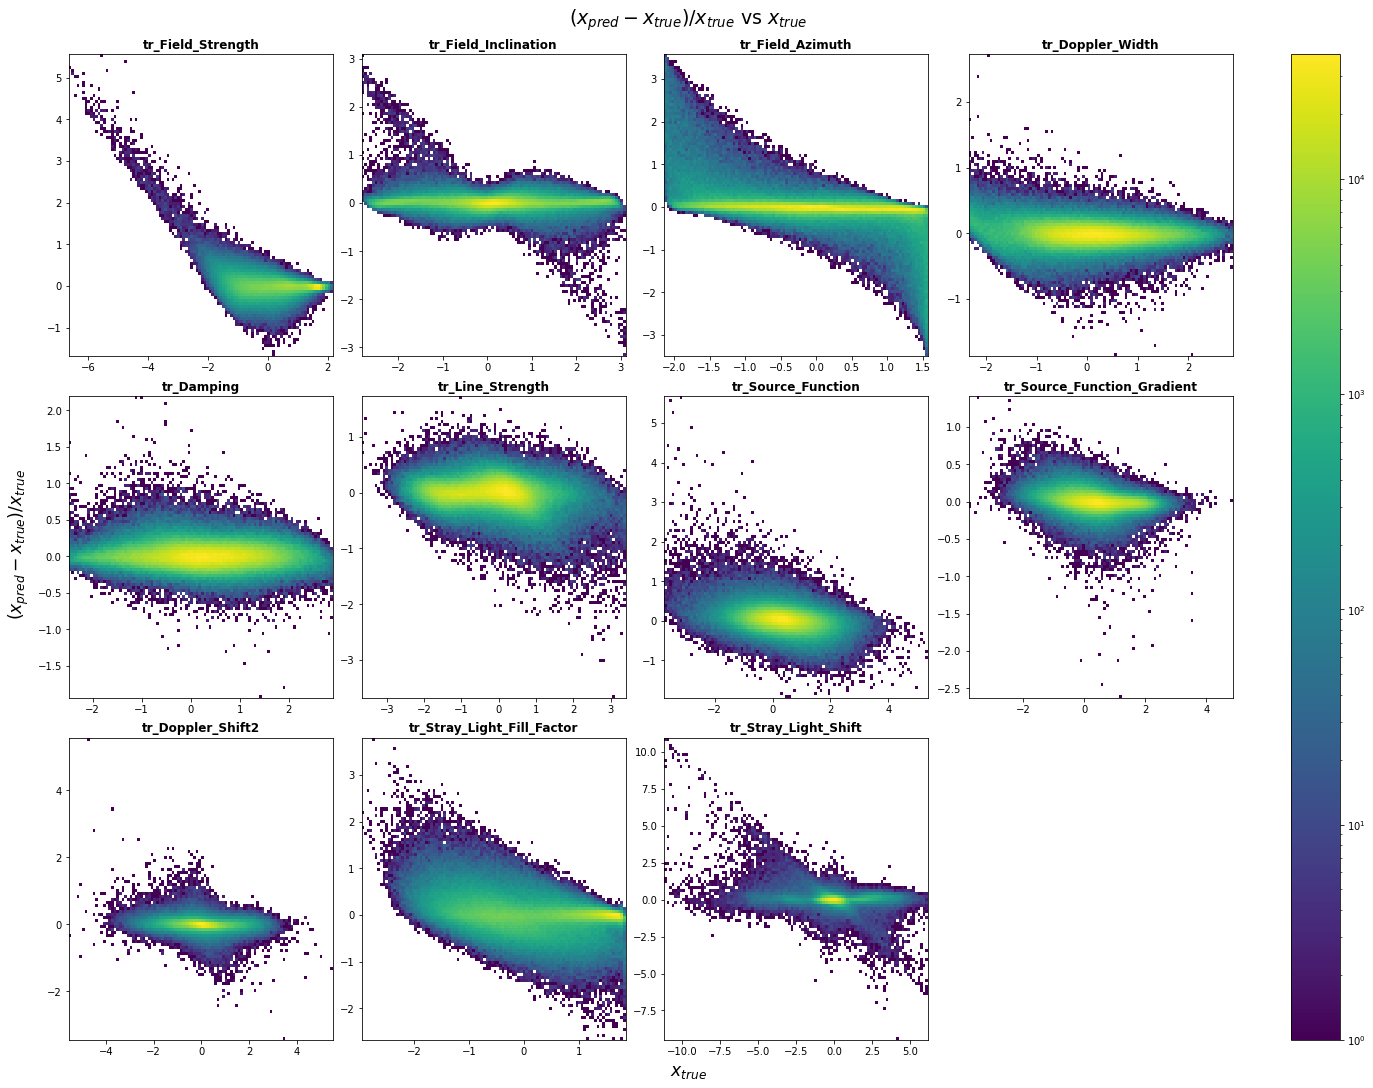

In [64]:
fig, axs = plot_analysis_hist2d(masked_ref_2d.data, predicted_2d, 
                                names=fe_names,
                                save_path=save_path+model_name+'_analysis_hist2d',
                                mask=masked_ref_2d.mask)

custom_xlim = (-3, 3)
# custom_ylim = (-1, 1)
# plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
# plt.setp(axs)

plt.show()

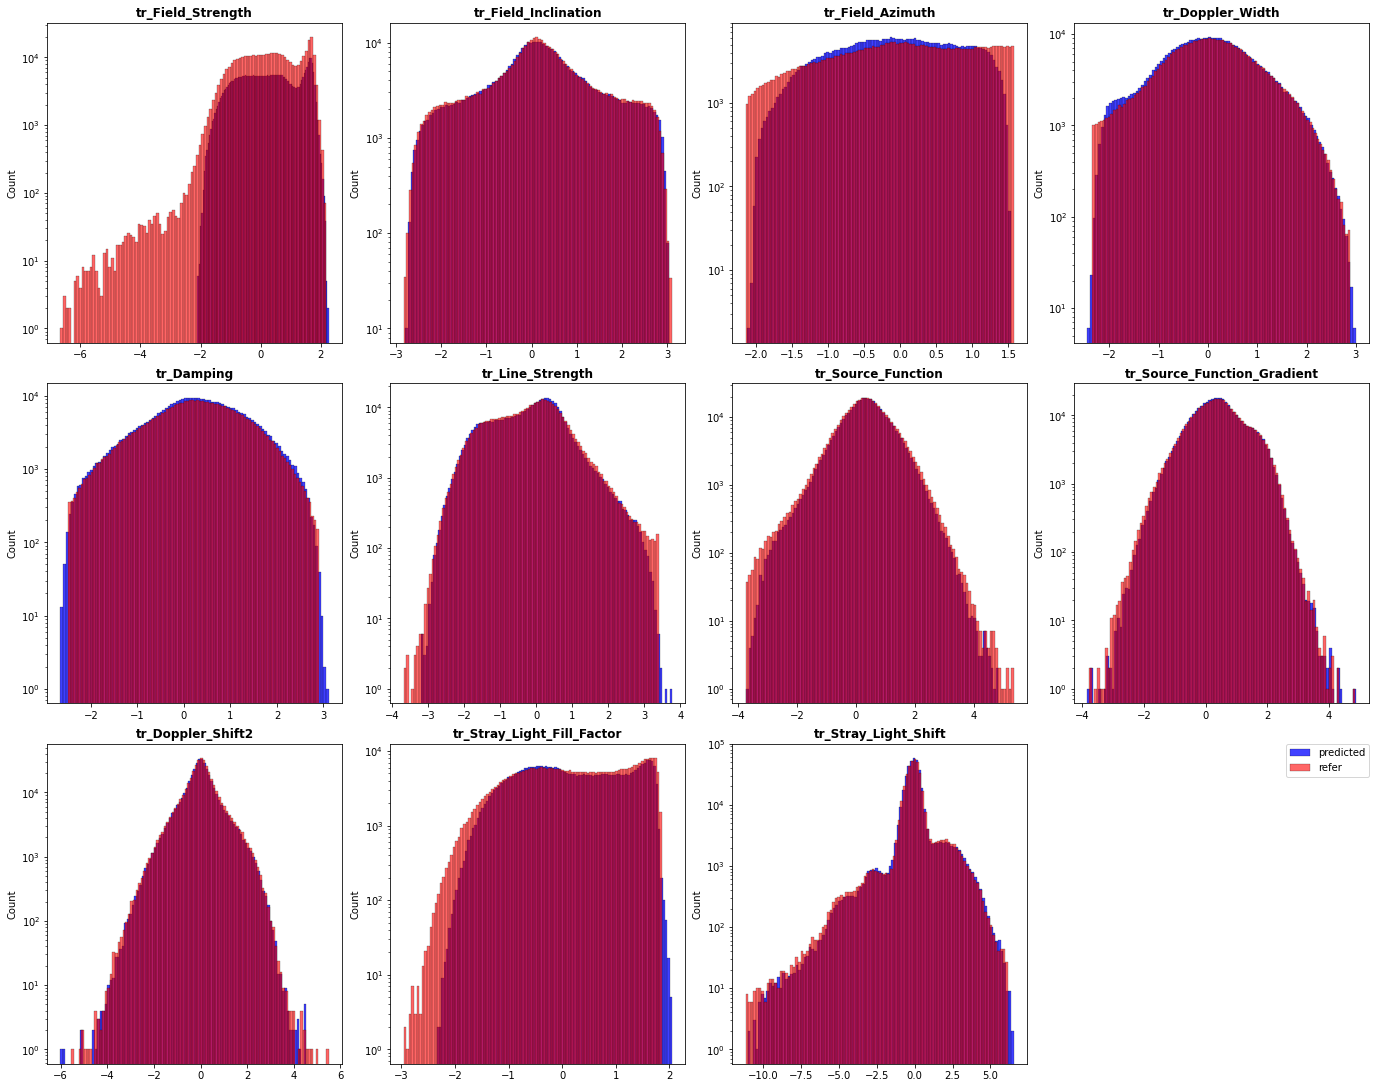

In [65]:
from inverse_problem.nn_inversion.posthoc import plot_hist_params_comparison

plot_hist_params_comparison(predicted_2d, masked_ref_2d.data, 
                            pars_names=fe_names,
                            save_path=save_path+model_name+'_comp_plot',
                            mask=masked_ref_2d.mask)

plt.show()

## Обратные преобразования параметров

In [66]:
predicted_2d_inv = pt.inverse_transform(predicted_2d)

In [68]:
compute_metrics(masked_ref_unnorm_2d.data, predicted_2d_inv, 
                mask=masked_ref_2d.mask,
                save_path=save_path+model_name+'_inv' + '.csv')

,r2,mse,mae
Field Strength,0.9883,2857.3530,36.7272
Field Inclination,0.9841,20.7887,2.6420
Field Azimuth,0.7513,631.5542,11.7167
Doppler Width,0.9774,1.7650,0.9237
Damping,0.9686,0.0011,0.0210
Line Strength,0.8952,7.9870,1.3250
S_0,0.9210,475845.0353,479.9496
S_1,0.9847,477996.8063,481.0746
Doppler Shift,0.9748,0.0171,0.0809
Filling Factor,0.8924,0.0062,0.0530


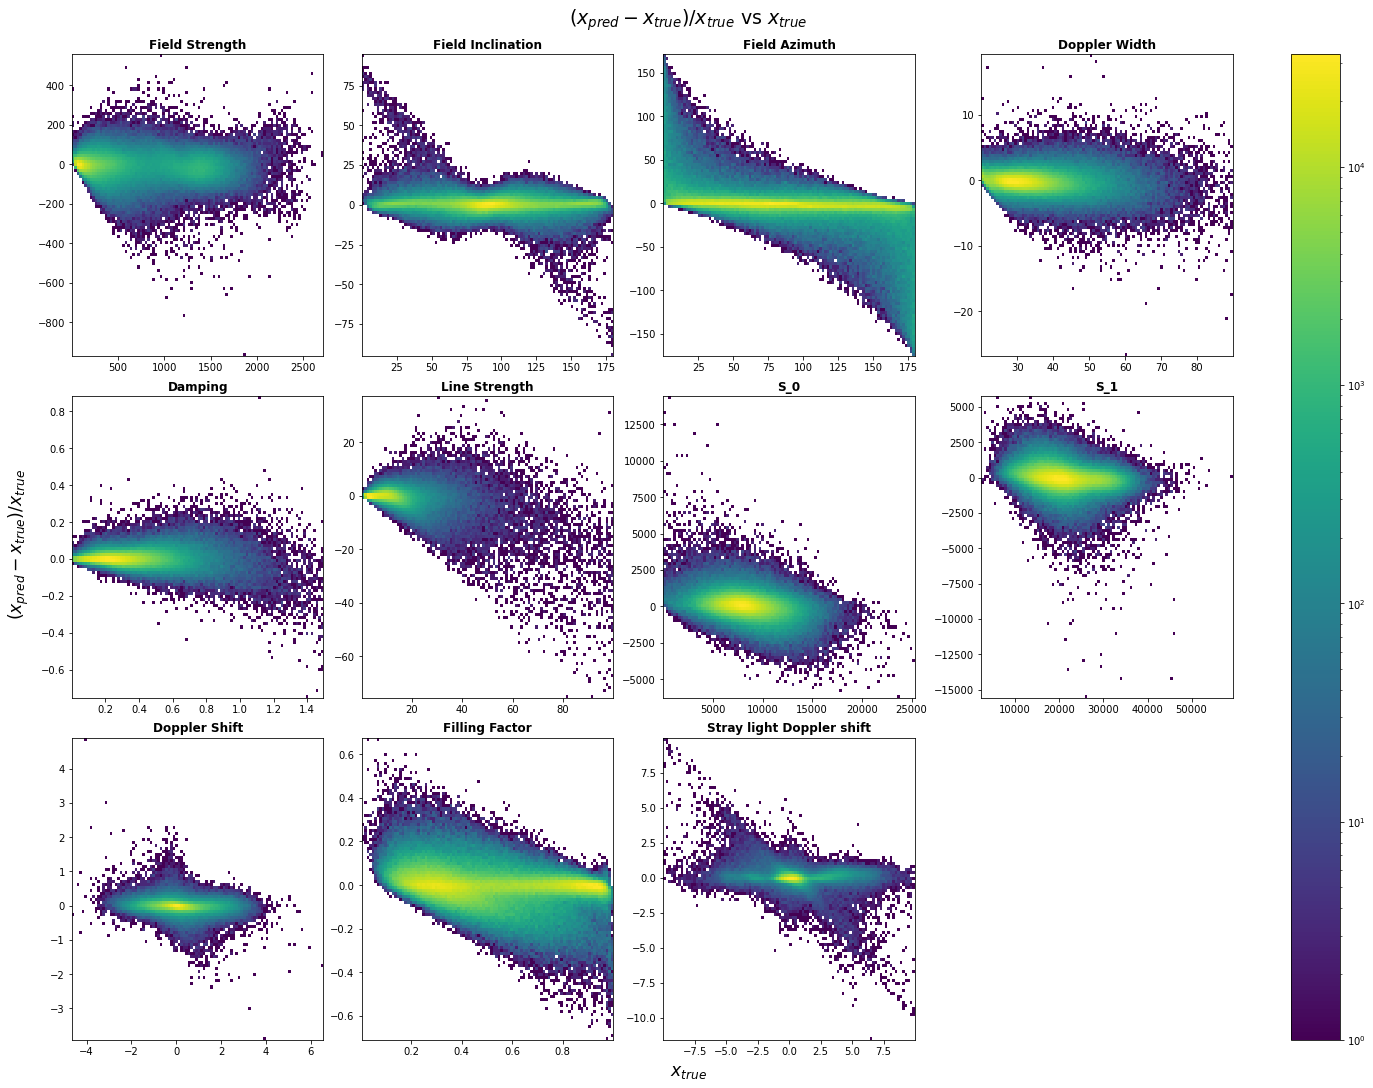

In [70]:
plot_analysis_hist2d(masked_ref_unnorm_2d.data, predicted_2d_inv, 
                     mask=masked_ref_2d.mask, 
                     save_path=save_path+model_name+'_analysis_hist2d_inv')

plt.show()

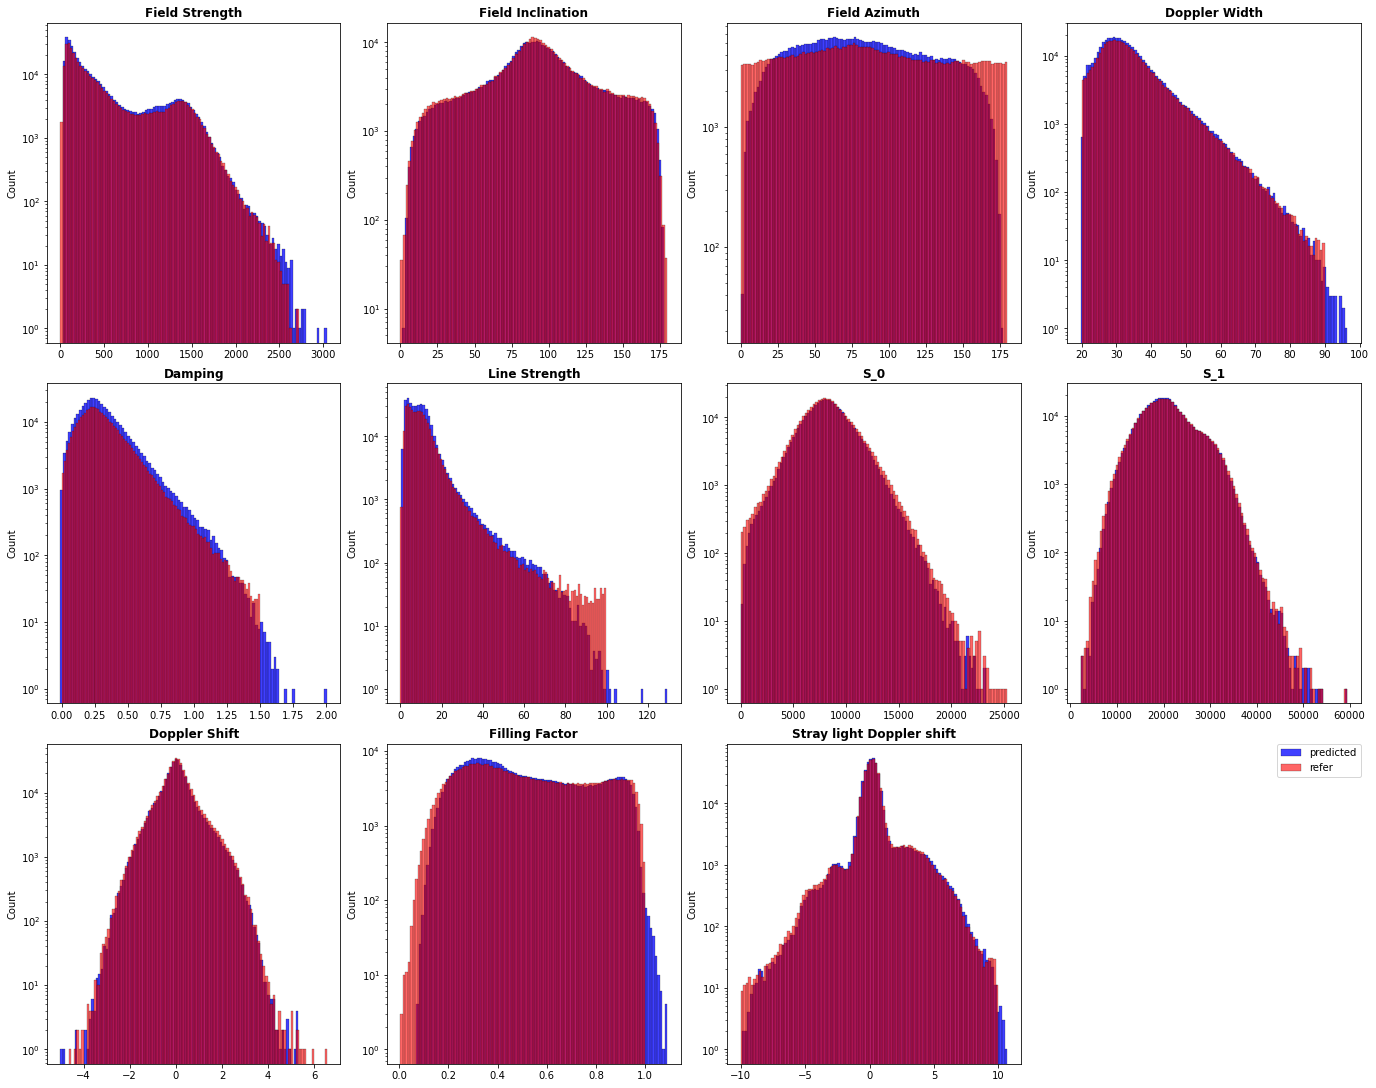

In [71]:
plot_hist_params_comparison(predicted_2d_inv, masked_ref_unnorm_2d.data, 
                            mask=masked_ref_2d.mask,
                            save_path=save_path+model_name+'_inv_comp_plot')
plt.show()

## Проверка на реальных спектрах

Спектры лежат в отдельной папочке sp_..... (много папочек в папочках, оставила так же как и лежит на хиноде). Спектры получаются последовательным сканированием щели, и результаты каждой в своем фитсе, всего 873, внутри каждой щели 512 спектров.

In [72]:
path_to_folder = '../data/hinode_source'
path_to_refer = '../data/hinode_source/20140926_170005.fits'

# date as a list with year, month,day, hour 
date = ['2014', '09', '26', '17']

sp_folder = os.path.join(path_to_folder, 'sp_20140926_170005')

sp_path = os.path.join(sp_folder, date[0], date[1], date[2], 'SP3D')
sp_path = glob.glob(f'{sp_path}/*/')[0]

sp_lines = sorted(glob.glob(sp_path + '*.fits'))
print(f'Number of files: {len(sp_lines)}')

Number of files: 873


In [ ]:
# можно побегать индексами и посравнивать спектры
idx_0, idx_1 = 22, 794
cont_int, real_line = plot_spectrum(sp_folder, date, path_to_refer, idx_0, idx_1)
refer, names = open_param_file(path_to_refer, print_params=False, normalize=False)
profile, cont_int = plot_model_spectrum(refer, names, idx_0, idx_1)

### Подготовка реальных спектров для модели

In [74]:
def prepare_real_conv(sp_folder, date, factors=None, cont_scale=None, device=None):
    real_samples, cont = read_spectrum_for_refer(sp_folder, date)
    norm_real_samples = normalize_spectrum(np.reshape(real_samples, (-1, 56, 4), order='F'),
                                           factors=factors)
    
    norm_cont = cont / cont_scale
    norm_real_samples = np.swapaxes(norm_real_samples, 1, 2)
    real_x = [torch.from_numpy(norm_real_samples).float().to(device), torch.from_numpy(norm_cont).float().to(device)]
    return real_x

In [75]:
%%time

transform = conv1d_transform_rescale(factors=factors, 
                                     angle_transformation=angle_transformation,
                                     cont_scale=cont_scale, logB=logB, PowerTransformer=pt)

test_dataset = PregenSpectrumDataset(data_arr=refer.reshape(-1, 11),
                                     transform=transform)

inputs = test_dataset.samples
sim_x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]

CPU times: user 1min 15s, sys: 12.2 s, total: 1min 27s
Wall time: 1min 28s


In [76]:
%%time

real_x = prepare_real_conv(sp_folder, date, factors=factors, cont_scale=cont_scale, device=device)

CPU times: user 6.29 s, sys: 2.88 s, total: 9.18 s
Wall time: 3min 1s


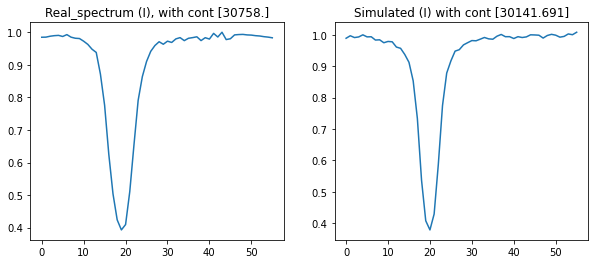

In [77]:
#тоже можно побегать индексом и увидеть, что наши симуляции довольно сильно отличаются
idx = 20000
#можно проверить, что все правильно сделали и посмотреть на координату пикселя
idx_0, idx_1 = np.where(np.arange(512 * 873).reshape(512, 873) == idx)

idx_0[0], idx_1[0] = idx_0, idx_1
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1); plt.plot(real_x[0][idx, 0].detach().cpu().numpy()); plt.title(f'Real_spectrum (I), with cont {real_x[1][idx].detach().cpu().numpy()*40000}')
plt.subplot(1,2,2);  plt.plot(sim_x[0][idx, 0].detach().cpu().numpy()); plt.title(f'Simulated (I) with cont {sim_x[1][idx].detach().cpu().numpy()*40000}');

In [78]:
model.eval()
with torch.no_grad():
    predicted_real = model(real_x)

In [79]:
predicted_real = predicted_real.detach().cpu().numpy()
predicted_real_2d = predicted_real.reshape(-1, 11).copy()

In [80]:
inv_predicted_real_2d = pt.inverse_transform(predicted_real_2d)

In [81]:
compute_metrics(refer, inv_predicted_real_2d,
#                 mask=mask_range,
                save_path=save_path+model_name+'_inv_real' + '.csv')

,r2,mse,mae
Field Strength,0.8556,4.671537e+04,141.9789
Field Inclination,0.9212,1.097694e+02,6.0125
Field Azimuth,0.5826,1.085692e+03,18.6864
Doppler Width,0.1921,8.015550e+01,5.9699
Damping,0.2397,4.170000e-02,0.1465
Line Strength,0.1516,1.138778e+02,4.8293
S_0,0.0992,8.861473e+06,2134.6771
S_1,0.5223,1.928367e+07,3197.8752
Doppler Shift,0.4855,1.032100e+00,0.8704
Filling Factor,0.2738,6.390000e-02,0.1948


In [ ]:
plot_pred_vs_refer(inv_predicted_real_2d.reshape(predicted_real.shape), refer,
                   output_index=0)

In [ ]:
plot_pred_vs_refer(inv_predicted_real_2d.reshape(predicted_real.shape), refer,
                   output_index=1)